# LINEAR Dataset Feature Selection

We will take on the LINEAR Dataset of variables, which contains higly reliable sample of ~7000 optically faint variables, observed with the Lincoln Near-Earth Asteroid Research survey, from 1998 to 2009.

Several classes of variables are present in this dataset, detailed below:

1. RR Lyr ab (2923); 
2. RR Lyr c (990); 
3. Algol-like with 1 minimum (20); 
4. Algol-like with 2 minima (357); 
5. contact binary (2385); 
6. delta Scu/SX Phe (112); 
7. long-period variable, including semi-regular variables (77); 
8. hearbeat candidates (1); 
9. BL Her (6); 
10. [yes, class 10 is missing]. 
11. anomalous Cepheids (5); 
0. other (318, including some quasars)  

We will perform a dataset exploration, and a feature selection using the *feets* library output features.

In [1]:
import os
import numpy as np
import pickle 
from pprint import pprint
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing as prp
from sklearn import decomposition as de
from sklearn import feature_selection as fs

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [8]:
from IPython import display as d

from lime import lime_tabular as lt

In [21]:
def from_ij_to_idx(i, j, n_i):
    idx = j * n_i + i
    return idx

def from_idx_to_ij(idx, n_i):
    frac = float(idx)/float(n_i)
    j = int(frac)
    i = int((frac - j) * n_i)
    return i, j

In [205]:
features = pd.read_pickle('features/features.pkl')

In [206]:
features = features.dropna(axis=0, how='any')

In [207]:
len(features.columns)

290

In [208]:
vartypes = ['RRLyrab', 'RRLyrc', 'Algol1', 'Algol2', 
            'CB', 'DScuti', 'LPVar', 'HBeat', 'BLHer', 
            'AnomCephei', 'Other']
types = features[['LCtype']]

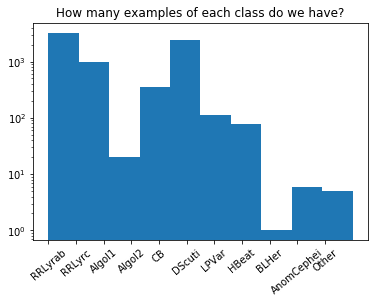

In [209]:
plt.hist(types.as_matrix(), log=True)
plt.xticks(range(11), vartypes, rotation=40)
plt.title('How many examples of each class do we have?')
plt.show()

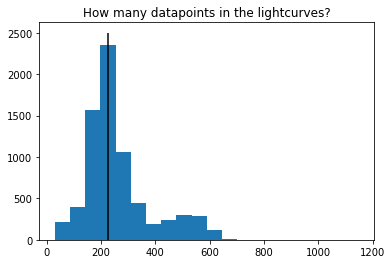

In [210]:
plt.hist(features['nObs'], bins=20)
plt.vlines(x=np.median(features['nObs']), ymax=2500, ymin=0)
plt.title('How many datapoints in the lightcurves?')
plt.show()

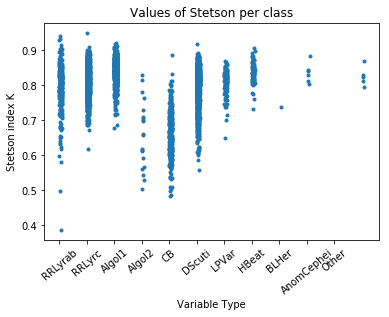

In [211]:
plt.plot(features['LCtype']+np.random.random(len(features))*0.1, 
         features['StetsonK'], '.')
plt.xlabel('Variable Type')
plt.xticks(range(11), ['RRLyrab', 'RRLyrc', 'Algol1', 'Algol2', 
            'CB', 'DScuti', 'LPVar', 'HBeat', 'BLHer', 
            'AnomCephei', 'Other'], rotation=40)
plt.ylabel('Stetson index K')
plt.title('Values of Stetson per class')
plt.show()

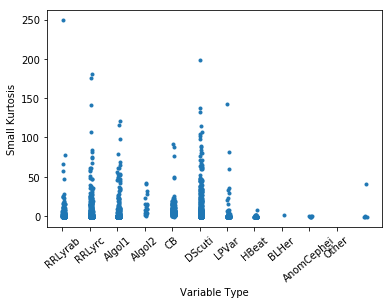

In [212]:
plt.plot(features['LCtype']+np.random.random(len(features))*0.1, 
         features['SmallKurtosis'], '.')
plt.xlabel('Variable Type')
plt.xticks(range(11), ['RRLyrab', 'RRLyrc', 'Algol1', 'Algol2', 
            'CB', 'DScuti', 'LPVar', 'HBeat', 'BLHer', 
            'AnomCephei', 'Other'], rotation=40)
plt.ylabel('Small Kurtosis')

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


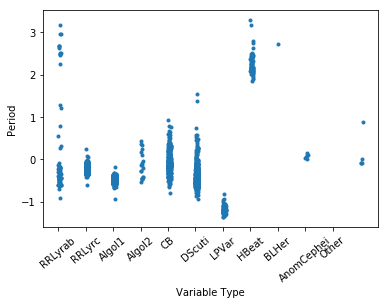

In [213]:
plt.plot(features['LCtype']+np.random.random(len(features))*0.1, 
         np.log10(features['P']), '.')
plt.xlabel('Variable Type')
plt.xticks(range(11), ['RRLyrab', 'RRLyrc', 'Algol1', 'Algol2', 
            'CB', 'DScuti', 'LPVar', 'HBeat', 'BLHer', 
            'AnomCephei', 'Other'], rotation=40)
plt.ylabel('Period')

In [214]:
n_t = 18 * 12
n_i = 12

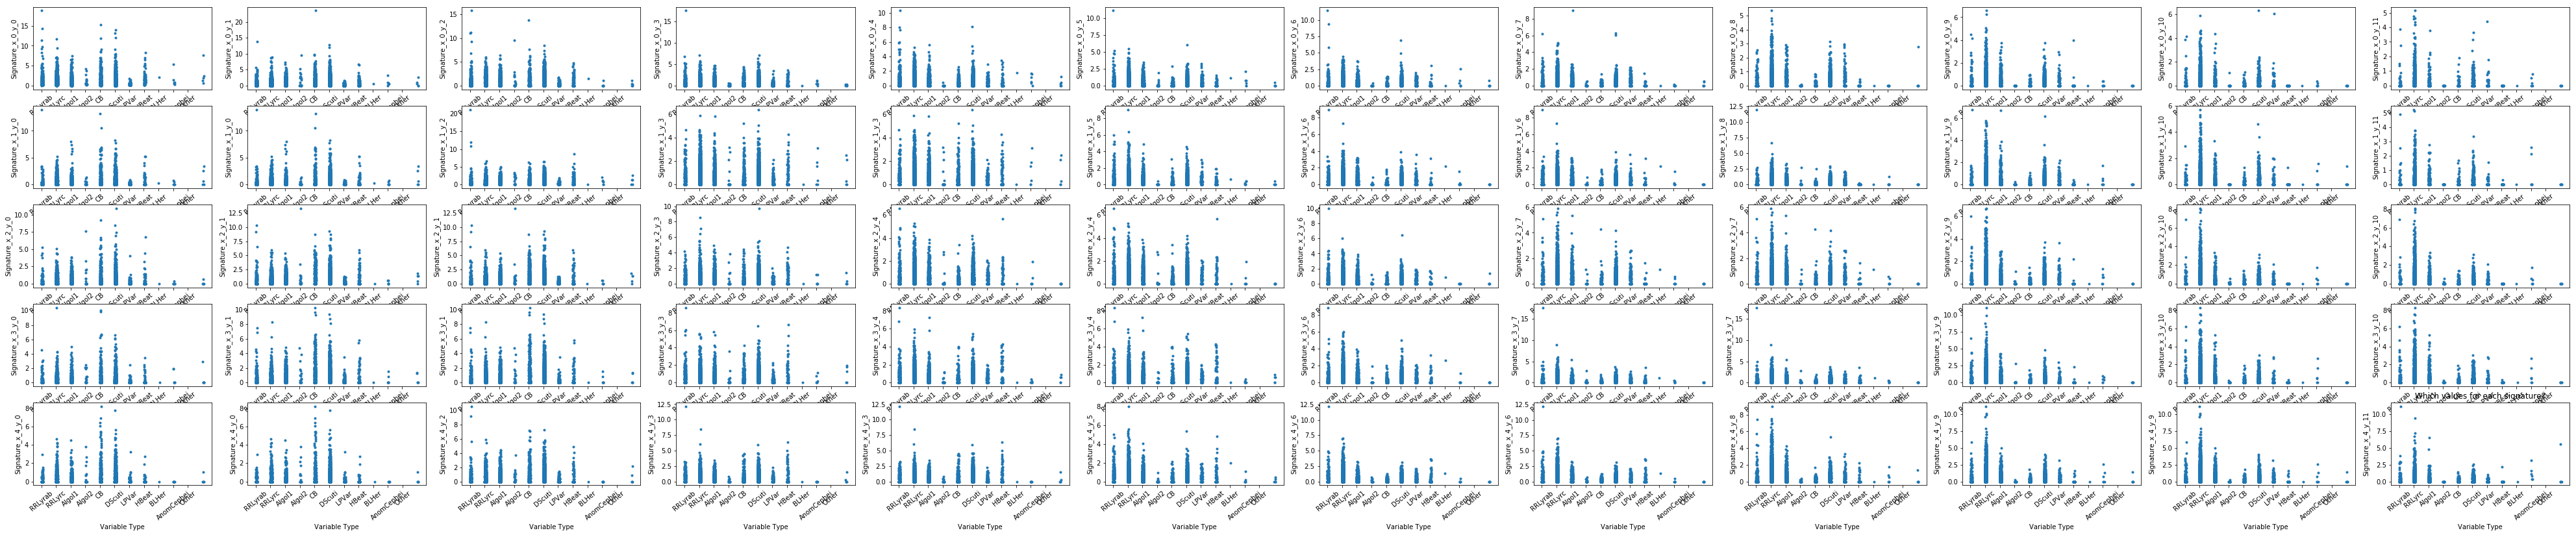

In [215]:
plt.figure(figsize=(70, 50))
for i in range(60):
    plt.subplot(18, 12, i+1)
    y, x = from_idx_to_ij(i, n_i)
    plt.plot(features['LCtype']+np.random.random(len(features))*0.1, 
             features['Signature_x_{}_y_{}'.format(x, y)], '.')
    plt.xlabel('Variable Type')
    plt.xticks(range(11), ['RRLyrab', 'RRLyrc', 'Algol1', 'Algol2', 
                'CB', 'DScuti', 'LPVar', 'HBeat', 'BLHer', 
                'AnomCephei', 'Other'], rotation=40)
    plt.ylabel('Signature_x_{}_y_{}'.format(x, y))
plt.title('Which values for each signature?')
plt.savefig('signatures.pdf', dpi=160)

In [216]:
def from_id_to_signature(starid, n_x=18, n_y=12):
    signature = np.empty((n_y, n_x))
    for x in range(n_x):
        for y in range(n_y):
            signature[y, x] = features.iloc[starid]['Signature_x_{}_y_{}'.format(x, y)]
    return signature

Let's keep the most populated lightcurves:

In [217]:
features = features[features['nObs'] < 15]

In [218]:
starid = 328
sign = from_id_to_signature(starid)
vartype = vartypes[int(features.iloc[starid]['LCtype'])]

IndexError: single positional indexer is out-of-bounds

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(np.tile(sign,2), origin='lower', cmap='viridis')
plt.title(vartype)
plt.show()

In [ ]:
signature_cols = features.columns[features.columns.str.startswith('Sign')]

In [ ]:
no_signature_cols = features.columns[~features.columns.str.startswith('Sign')][2:]

In [ ]:
print no_signature_cols

In [ ]:
def experiment(clf, x, y, nfolds=10, printing=False):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = None # np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)#[:, 0]
        
        #if probabilities is not None: print 'probabilities.shape = ',probabilities.shape 
        #print 'probs.shape = ', probs.shape
        #print 'predict.shape = ', pr.shape
        probabilities = (
            probs if probabilities is None else
            np.vstack([probabilities, probs]))
        
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    if printing: 
        print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities[:, 0])
    prec_rec_curve = metrics.precision_recall_curve(y_testing, 1.- probabilities[:, 0])
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

In [ ]:
rrlyra = features.LCtype == 1
rrlyrc = features.LCtype == 2
cbinar = features.LCtype == 5

In [ ]:
subset = features[rrlyra | cbinar]

In [ ]:
X = subset[signature_cols].as_matrix()
Y = subset.LCtype.values > 1

In [ ]:
pca = decomposition.PCA(svd_solver='randomized', n_components=5)
pca.fit(X)

In [ ]:
X_tr = pca.transform(X)

In [ ]:
pd.scatter_matrix(pd.DataFrame(X_tr), alpha=0.1, figsize=(12, 12), diagonal='kde')
plt.grid()
plt.show()

In [ ]:
X_tr.shape

In [ ]:
Y.shape

In [ ]:
resDtree = experiment(DecisionTreeClassifier(min_samples_leaf=5),
                               X_tr, Y, printing=True)
resRForest = experiment(RandomForestClassifier(n_estimators=1000, min_samples_leaf=5, n_jobs=6),
                               X, Y, printing=True)

In [ ]:
X_sign = subset[signature_cols].as_matrix()
X_nosg = subset[no_signature_cols].as_matrix()

In [ ]:
resRForest_sign = experiment(RandomForestClassifier(n_estimators=1000, min_samples_leaf=5, n_jobs=6),
                               X_sign, Y, printing=True)
resRForest_nosg = experiment(RandomForestClassifier(n_estimators=1000, min_samples_leaf=5, n_jobs=6),
                               X_nosg, Y, printing=True)

In [146]:
train, test, labels_train, labels_test = train_test_split(
    X_sign, Y, train_size=0.80)

def get_bests(probs, n=1):
    probs = probs[:,0]
    indexes = np.argsort(probs)
    return indexes[-n:], indexes[:n]

classes = {
    "SVC - Linear Kernel": 
        svm.SVC(kernel='linear', probability=True),
    "SVC - Polynomic Kernel": 
        svm.SVC(kernel='poly', probability=True),
    "Random Forest": 
        RandomForestClassifier(n_estimators=500, criterion="entropy"),
    "KNN": 
        KNeighborsClassifier(n_neighbors=3, weights='distance')}

for idx, clf_data in enumerate(classes.items()):
    cls_name, clf = clf_data
    d.display(d.Markdown(
        "### 3.1.{} {} Explanation".format(idx+1, cls_name)))
    
    print "Fitting '{}'...".format(cls_name)
    %time clf.fit(train, labels_train)
    
    print "Predicting '{}'...".format(cls_name)
    %time probs = clf.predict_proba(test)
    
    # finding best observations
    best_nv_idx, best_rr_idx =  get_bests(probs)
    best_nv, best_rr = (
        test[best_nv_idx][0], 
        test[best_rr_idx][0])
    
    print "Explaining '{}'...".format(cls_name)
    explainer = lt.LimeTabularExplainer(
        train, feature_names=signature_cols.tolist(), 
        class_names=["RRLyrab", "RRLyrc"], 
        discretize_continuous=True)
    
    d.display(d.Markdown(
        "#### {} (Best NV)".format(cls_name)))
    exp = explainer.explain_instance(
        best_nv, clf.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=False)
    
    d.display(d.Markdown(
        "#### {} (Best RR)".format(cls_name)))
    exp = explainer.explain_instance(
        best_rr, clf.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=False)
    d.display(d.Markdown("----"))

NameError: name 'train_test_split' is not defined

In [ ]:
train, test, labels_train, labels_test = train_test_split(
    X_nosg, Y, train_size=0.80)

def get_bests(probs, n=1):
    probs = probs[:,0]
    indexes = np.argsort(probs)
    return indexes[-n:], indexes[:n]

classes = {
    "SVC - Linear Kernel": 
        svm.SVC(kernel='linear', probability=True),
    "SVC - Polynomic Kernel": 
        svm.SVC(kernel='poly', probability=True),
    "Random Forest": 
        RandomForestClassifier(n_estimators=500, criterion="entropy"),
    "KNN": 
        KNeighborsClassifier(n_neighbors=3, weights='distance')}

for idx, clf_data in enumerate(classes.items()):
    cls_name, clf = clf_data
    d.display(d.Markdown(
        "### 3.1.{} {} Explanation".format(idx+1, cls_name)))
    
    print "Fitting '{}'...".format(cls_name)
    %time clf.fit(train, labels_train)
    
    print "Predicting '{}'...".format(cls_name)
    %time probs = clf.predict_proba(test)
    
    # finding best observations
    best_nv_idx, best_rr_idx =  get_bests(probs)
    best_nv, best_rr = (
        test[best_nv_idx][0], 
        test[best_rr_idx][0])
    
    print "Explaining '{}'...".format(cls_name)
    explainer = lt.LimeTabularExplainer(
        train, feature_names=no_signature_cols.tolist(), 
        class_names=["RRLyrab", "RRLyrc"], 
        discretize_continuous=True)
    
    d.display(d.Markdown(
        "#### {} (Best NV)".format(cls_name)))
    exp = explainer.explain_instance(
        best_nv, clf.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=False)
    
    d.display(d.Markdown(
        "#### {} (Best RR)".format(cls_name)))
    exp = explainer.explain_instance(
        best_rr, clf.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True, show_all=False)
    d.display(d.Markdown("----"))

### 3.1.1 SVC - Polynomic Kernel Explanation

Fitting 'SVC - Polynomic Kernel'...
CPU times: user 1.88 s, sys: 0 ns, total: 1.88 s
Wall time: 1.88 s
Predicting 'SVC - Polynomic Kernel'...
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 20.4 ms
Explaining 'SVC - Polynomic Kernel'...


#### SVC - Polynomic Kernel (Best NV)

#### SVC - Polynomic Kernel (Best RR)

----

### 3.1.2 KNN Explanation

Fitting 'KNN'...
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.58 ms
Predicting 'KNN'...
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 17.2 ms
Explaining 'KNN'...


#### KNN (Best NV)

#### KNN (Best RR)

----

### 3.1.3 SVC - Linear Kernel Explanation

Fitting 'SVC - Linear Kernel'...


## True feature selection

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2
